# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [128]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [129]:
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.axis('off')
    plt.imshow(new_image)

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

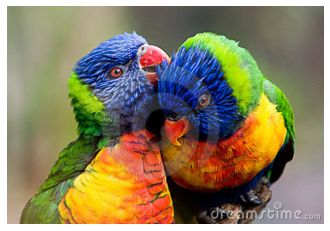

In [130]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [131]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [132]:
K = [2, 3, 10, 20]

>### KMeans

In [133]:
def color_reduction_kmeans(k, vis):

    Z = img.reshape((-1, 3))

    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    if vis: draw_picture(res2)

    if not vis: return res2

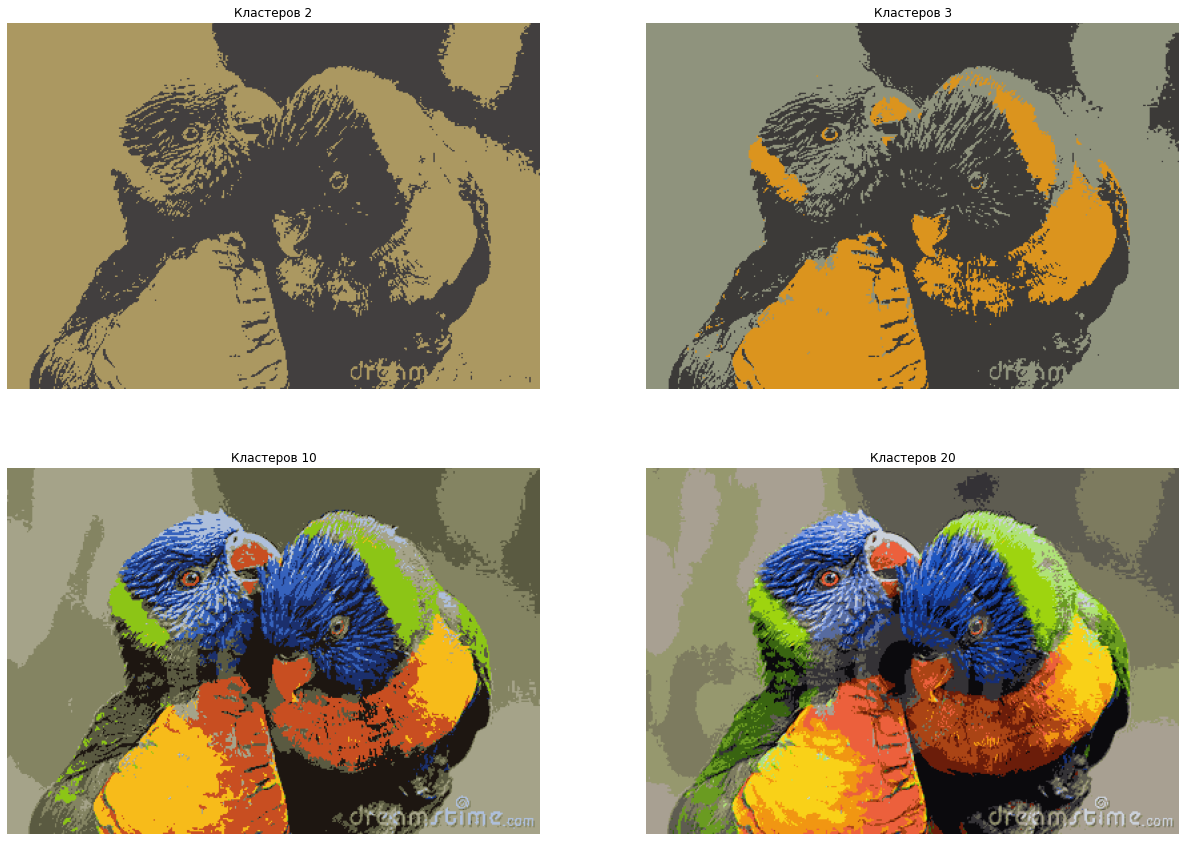

In [134]:
plt.figure(figsize=(21, 15))

score_kmeans = []

for num, k in enumerate(K):

    plt.subplot(2, 2, num + 1)
    plt.title('Кластеров {}'.format(k))
    color_reduction_kmeans(k, vis=True)
    
    new_img = color_reduction_kmeans(k, vis=False)
    score_kmeans.append(ssim(img, new_img, win_size=3))

>### DBSCAN

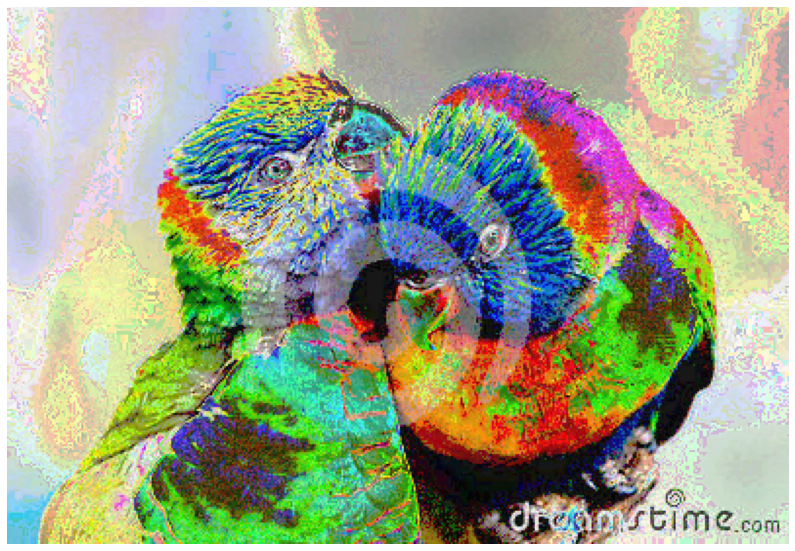

In [135]:
from sklearn.cluster import DBSCAN

db = 255 - DBSCAN(eps=0.3, min_samples=1).fit_predict(img.reshape((-1, 1)))

plt.figure(figsize=(14, 10))

draw_picture(db.reshape(img.shape))

score_dbscan = ssim(np.float64(img), np.float64(db.reshape(img.shape)), win_size=3)

>### AgglomerativeClustering

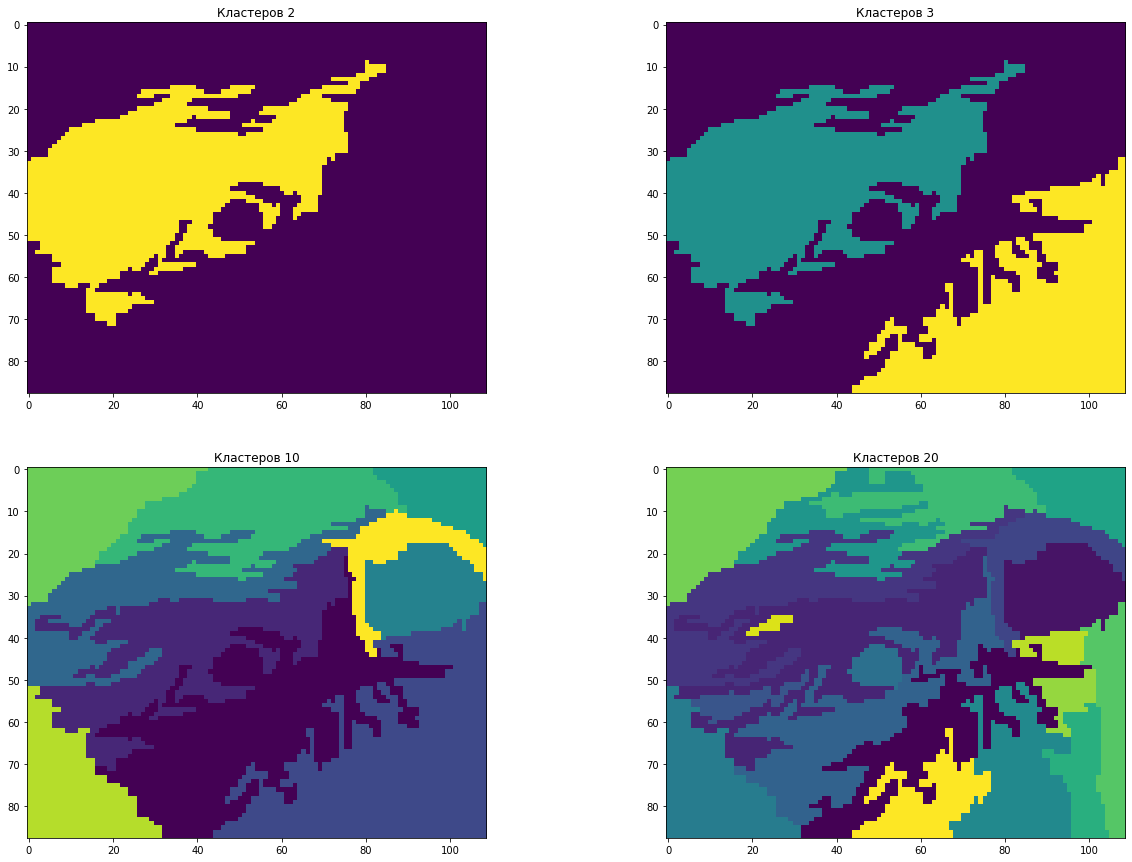

In [136]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

img = cv2.imread('bird.jpg')

plt.figure(figsize=(21, 15))

score_ac = []

connectivity = grid_to_graph(*img.shape[:2])

for num, k in enumerate(K):

    ac = AgglomerativeClustering(k, connectivity=connectivity).fit_predict(img.reshape(-1, 3))

    plt.subplot(2, 2, num + 1)
    plt.title('Кластеров {}'.format(k))
    plt.imshow(ac.reshape(img.shape[:2]))

    score_ac.append(ssim(np.float32(img).mean(axis=2), np.float32(ac.reshape(img.shape[:2])), win_size=3))

In [141]:
import pandas as pd
display(pd.DataFrame({'KMeans': score_kmeans, 'AC': score_ac}, index=K))
print('DBSCAN accuracy is {}'.format(score_dbscan))

,KMeans,AC
2,0.451967,-0.000027
3,0.557120,-0.000094
10,0.767800,0.002811
20,0.839868,0.003424


DBSCAN accuracy is 0.1907203694988383


# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [4]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [5]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [7]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [8]:
y.shape

(2370,)

In [9]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

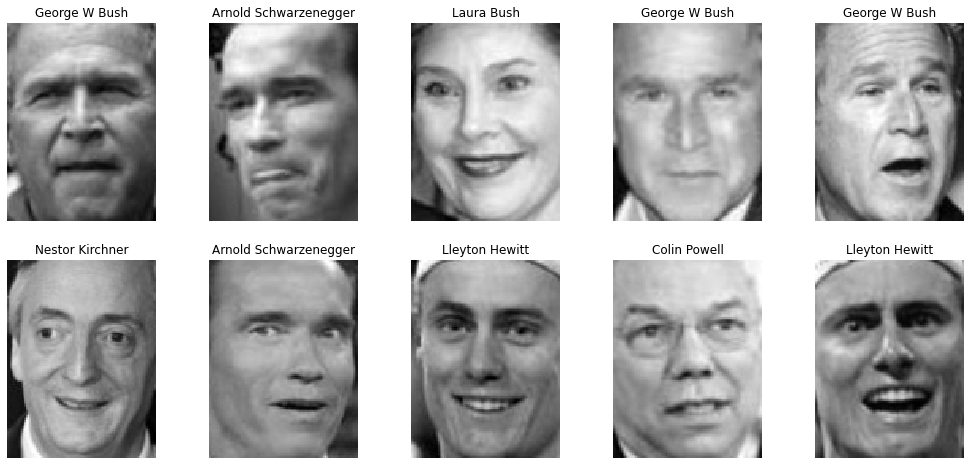

In [10]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

>### Без уменьшения размерности

In [92]:
from sklearn.linear_model import LogisticRegression

In [124]:
acc = np.zeros(10)
for i in range(1, 11):
    model = LogisticRegression(penalty='l2', C=i / 10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc[i - 1] = (y_pred == y_test).mean()
    
print('best accuracy is {} for C = {}'.format(acc.max(), (acc.argmax() + 1) / 10))

best accuracy is 0.70042194092827 for C = 0.1


In [125]:
model = LogisticRegression(penalty='l2', C=(acc.argmax() + 1) / 10).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [126]:
def mistakes(y_pred):
  index = np.random.randint(0, 474, 5, dtype=int)
  plot_grid(y_test[1 - (y_pred == y_test)[index]], 1, 5)
  print('Предсказанные имена {}'.format(names[y_pred[1 - (y_pred == y_test)[index]]]))

Предсказанные имена ['Jacques Chirac' 'Hugo Chavez' 'Jacques Chirac' 'Jacques Chirac'
 'Jacques Chirac']


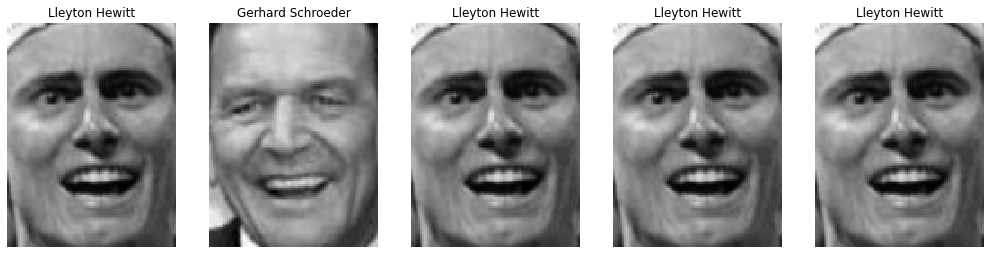

In [127]:
mistakes(y_pred)

>### Уменьшение размерности

>Воспользуемся алгоритмом PCA, так как он позваляет использовать размерность больше 3

In [131]:
from sklearn.decomposition import PCA

In [130]:
dim = range(1, 11)
acc = np.zeros(10)

for i in dim:
   pca = PCA(n_components=i)
   X_pca_train = pca.fit_transform(X_train)
   model = LogisticRegression().fit(X_pca_train, y_train)
   X_pca_test = pca.fit_transform(X_test)
   y_pred = model.predict(X_pca_test)
   acc[i - 1] = (y_pred == y_test).mean()

print('best accuracy is {} for {} dimensions'.format(acc.max(), (acc.argmax() + 1)))

best accuracy is 0.2468354430379747 for 7 dimensions


In [132]:
pca = PCA(n_components=acc.max())
X_pca_train = pca.fit_transform(X_train)
model = LogisticRegression().fit(X_pca_train, y_train)
X_pca_test = pca.fit_transform(X_test)
y_pred = model.predict(X_pca_test)

Предсказанные имена ['Colin Powell' 'Colin Powell' 'Colin Powell' 'Colin Powell'
 'Colin Powell']


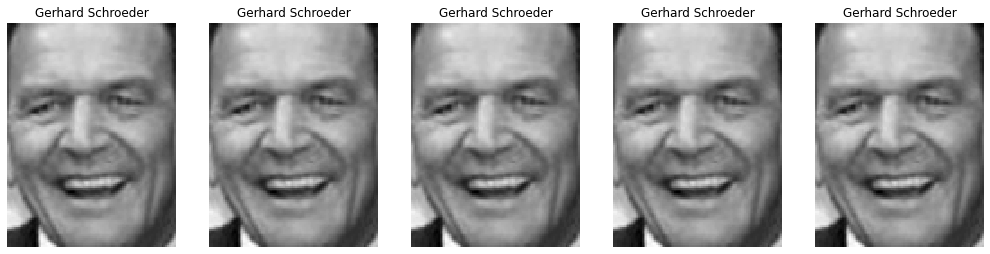

In [133]:
mistakes(y_pred)

>### Самый популярный класс

In [118]:
import pandas as pd
a = pd.DataFrame({'names': y})
a['names'].value_counts()

8     530
5     236
31    144
7     121
9     109
3      77
13     71
19     60
15     55
17     53
28     52
14     52
33     49
23     48
10     44
4      42
16     42
22     41
21     41
0      39
12     39
25     37
2      36
1      35
24     33
30     33
29     33
20     32
27     32
32     32
18     31
6      31
26     30
11     30
Name: names, dtype: int64

In [137]:
y_pred = np.full_like(y_test, 8)
print('accuracy is {}'.format((y_pred == y_test).mean()))

accuracy is 0.23839662447257384


>Значительного прогресса модель с уменьшением размерности не даёт. Однако модель без уменьшения размерности показала себя очень хорошо.

>Построим плоскость с помощью алгоритма TSNE, так как он гораздо лучше классифицирует в двумерном случае

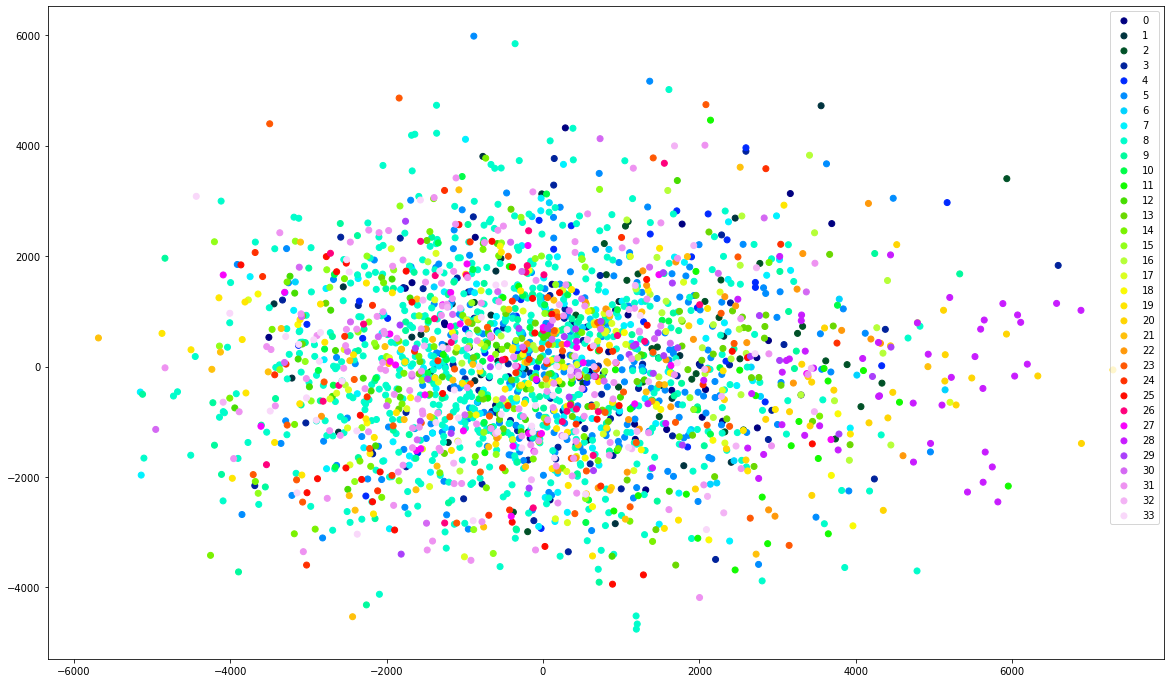

In [152]:
from matplotlib.colors import Normalize

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(20, 12))

for num, val in enumerate(set(y)):
    norm = Normalize(vmin=0, vmax=len(set(y)))
    color = plt.cm.gist_ncar(norm(num))
    plt.scatter(X_pca[:, 0][y == val], X_pca[:, 1][y == val], c=[color] * len(X_pca[:, 0][y == val]), label=val)

plt.legend()
plt.show()

>Нельзя хорошо различить кластеры